Lasso, Ridge, Randomforest, ElasticNet, GradientBoostingRegressor, LGBM(dart), XGB(otherBoosting), AdaBoostRegressor

# 1. Import

In [1]:
# Basic Library
import os
import pandas as pd
import numpy as np
import pickle
from itertools import permutations, combinations
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import xgboost as xgb

In [2]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("../pickle")
create_dir("../model")
create_dir("../submission")

Directory already existed : ../pickle
Directory already existed : ../model
Directory already existed : ../submission


In [3]:
train = pd.read_csv("../data/train_f1.csv")
test = pd.read_csv("../data/test_f1.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [4]:
def reduce_mem_usage(data):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']
    start_memory = data.memory_usage().sum() / 1024**2    
    for col in data.columns:
        col_type = data[col].dtypes
        if col_type in numerics:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)    
    end_memory = data.memory_usage().sum() / 1024**2
    print('Memory optimization from {:5.2f}MB to {:5.2f}MB ({:.1f}% reduction)'
          .format(start_memory, end_memory, 100 * (start_memory - end_memory) / start_memory))
    return data

In [5]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory optimization from 65.33MB to 16.34MB (75.0% reduction)
Memory optimization from 152.43MB to 38.13MB (75.0% reduction)


In [6]:
rows_train = train.shape[0] # 주어진 train data의 row 수
rows_test = test.shape[0] # 주어진 test data의 row 수
num_trial = 50 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 5 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 15 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed_hp = 3 # 파라미터 튜닝 seed 개수
num_seed_tr = 10 # 트레이닝 seed 개수
sel_seed = 3 # 선택할 seed 개수

In [7]:
pred_dict = {}
pred_test_dict = {}

# 2. LightGBM

In [5]:
train_lab = train.copy()
test_lab = test.copy()

for col in train_lab.columns:
    if train_lab[col].dtypes=='object':
        train_lab[col] = train_lab[col].astype('category')
        test_lab[col] = test_lab[col].astype('category')

train_x = train_lab.drop(['Target'], axis=1) # 데이터 나누기
train_y = train_lab['Target']
test_x = test_lab.copy()

print('Category Encoding Completed')

Category Encoding Completed


In [44]:
def lgb_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, num_seed_hp):
        params_lgb = {
            "random_state": seed_hp,
            "verbosity": -1,
            "n_estimators": 10000,
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1), # default=0.1, range=[0,1]
            "max_depth": trial.suggest_int("max_depth", 4, 12), # default=-1
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1e+2), # default=0
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1e+2), # default=0
            "num_leaves": trial.suggest_int("num_leaves", 31, 5000), # default=31, range=(1,130172]
            "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.0, 1.0), # feature_fraction, default=1
            "subsample": trial.suggest_uniform("subsample", 0.0, 1.0), # bagging_fraction, default=1, range=[0,1]
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 20), # bagging_freq, default=0
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 40), # min_data_in_leaf, default=20 
            "max_bin": trial.suggest_int("max_bin", 100, 500),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True) # Cross-validation cv=5
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

            x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values

            lgbmodel = LGBMRegressor(**params_lgb)
                                                                                            # 진행상황 보고싶을때 -1을 100으로
            lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1) 
            cv[val_idx] = lgbmodel.predict(x_val)
            
        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
    return np.mean(score_hp)

In [20]:
sampler = TPESampler(seed=basic_seed)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="minimize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=num_trial)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'n_estimators':10000}
lgb_best_hyperparams.update(lgb_base_hyperparams)

with open('../pickle/lgb_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(lgb_best_hyperparams, fw)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2022-03-25 04:23:51,988] A new study created in memory with name: lgb_parameter_opt
[I 2022-03-25 04:25:04,686] Trial 0 finished with value: 2.940613040683704 and parameters: {'learning_rate': 0.005611516415334507, 'max_depth': 12, 'reg_alpha': 8.471801418819979, 'reg_lambda': 2.481040974867813, 'num_leaves': 806, 'colsample_bytree': 0.15599452033620265, 'subsample': 0.05808361216819946, 'subsample_freq': 18, 'min_child_samples': 25, 'max_bin': 383}. Best is trial 0 with value: 2.940613040683704.
[I 2022-03-25 04:31:22,658] Trial 1 finished with value: 1.5241236013207289 and parameters: {'learning_rate': 0.0010994335574766201, 'max_depth': 12, 'reg_alpha': 21.368329072358772, 'reg_lambda': 0.07068974950624607, 'num_leaves': 934, 'colsample_bytree': 0.18340450985343382, 'subsample': 0.3042422429595377, 'subsample_freq': 11, 'min_child_samples': 18, 'max_bin': 216}. Best is trial 1 with value: 1.5241236013207289.
[I 2022-03-25 04:32:38,132] Trial 2 finished with value: 1.5417984259447

[I 2022-03-25 06:13:40,665] Trial 19 finished with value: 1.5046697343903634 and parameters: {'learning_rate': 0.007731789801741323, 'max_depth': 8, 'reg_alpha': 0.03465029611882152, 'reg_lambda': 2.3317816159027287, 'num_leaves': 2204, 'colsample_bytree': 0.3976506315305586, 'subsample': 0.3806868548165709, 'subsample_freq': 1, 'min_child_samples': 34, 'max_bin': 234}. Best is trial 3 with value: 1.496307303880717.
[I 2022-03-25 06:14:43,621] Trial 20 finished with value: 1.5484691179009846 and parameters: {'learning_rate': 0.02909604003142706, 'max_depth': 7, 'reg_alpha': 0.0332809868279227, 'reg_lambda': 0.07173346607008386, 'num_leaves': 2993, 'colsample_bytree': 0.3785932101573172, 'subsample': 0.21776823116137567, 'subsample_freq': 15, 'min_child_samples': 27, 'max_bin': 261}. Best is trial 3 with value: 1.496307303880717.
[I 2022-03-25 06:17:14,184] Trial 21 finished with value: 1.5056574014752837 and parameters: {'learning_rate': 0.009400079162806442, 'max_depth': 8, 'reg_alpha

[I 2022-03-25 07:06:46,152] Trial 38 finished with value: 1.513825966166732 and parameters: {'learning_rate': 0.05190939849624387, 'max_depth': 8, 'reg_alpha': 0.024405238809703446, 'reg_lambda': 4.157762961653591, 'num_leaves': 1605, 'colsample_bytree': 0.19768397879723684, 'subsample': 0.3342492092432078, 'subsample_freq': 5, 'min_child_samples': 23, 'max_bin': 227}. Best is trial 3 with value: 1.496307303880717.
[I 2022-03-25 07:32:09,051] Trial 39 finished with value: 1.5152527297397667 and parameters: {'learning_rate': 0.0011895953979898495, 'max_depth': 5, 'reg_alpha': 0.011012156852793085, 'reg_lambda': 0.36393176902110724, 'num_leaves': 3127, 'colsample_bytree': 0.5944027006843046, 'subsample': 0.27926747748135083, 'subsample_freq': 1, 'min_child_samples': 7, 'max_bin': 271}. Best is trial 3 with value: 1.496307303880717.
[I 2022-03-25 07:33:53,136] Trial 40 finished with value: 1.5176135038873204 and parameters: {'learning_rate': 0.02085973924974257, 'max_depth': 7, 'reg_alpha

The best hyperparameters are:
 {'learning_rate': 0.016409286730647923, 'max_depth': 5, 'reg_alpha': 0.018205657658407266, 'reg_lambda': 62.451395747430766, 'num_leaves': 4830, 'colsample_bytree': 0.8083973481164611, 'subsample': 0.3046137691733707, 'subsample_freq': 2, 'min_child_samples': 28, 'max_bin': 276, 'n_estimators': 10000}


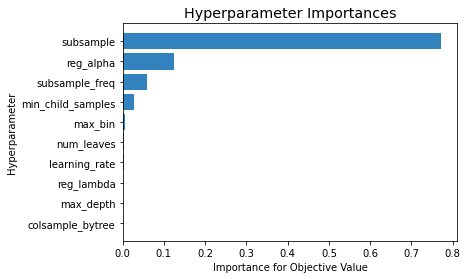

In [21]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

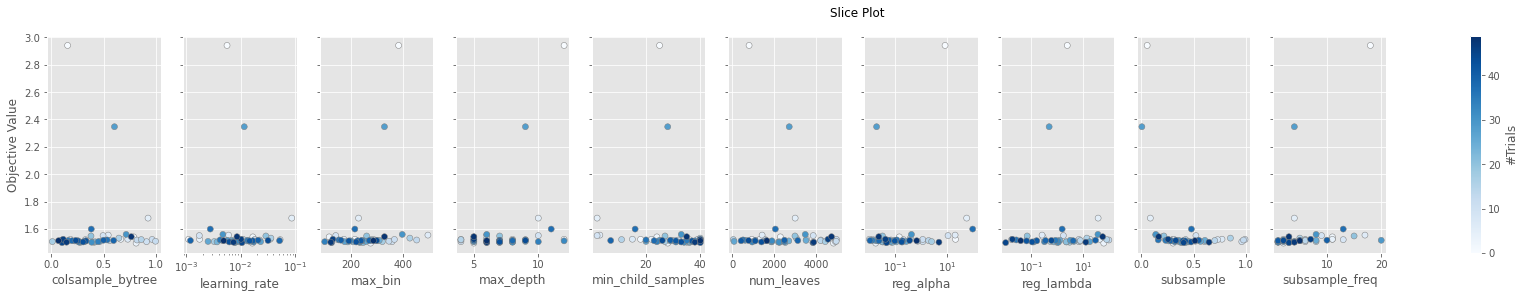

In [22]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

In [ ]:
# with open('../pickle/lgb_best_hyperparams.pickle', 'rb') as fw:
#     lgb_best_hyperparams = pickle.load(fw)

In [23]:
lucky_seeds = np.random.randint(0, 1000, num_seed_tr)

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle=True) # CV 늘려가면서 하기
    cv = np.zeros(rows_train)
    pred_test = np.zeros(rows_test)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMRegressor(**lgb_best_hyperparams)
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1)
        
        cv[val_idx] = lgbmodel.predict(x_val)
        pred_test += lgbmodel.predict(test_x) / splits_tr
        
    pred_dict['lgb'+str(seed)] = cv
    pred_test_dict['lgb'+str(seed)] = pred_test
    print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))

seed 81 mean_absolute_error : 1.5103172592193435
seed 672 mean_absolute_error : 1.503274367016825
seed 808 mean_absolute_error : 1.505958932276833
seed 996 mean_absolute_error : 1.4961064468471394
seed 847 mean_absolute_error : 1.512225732228379
seed 722 mean_absolute_error : 1.5009954152167524
seed 809 mean_absolute_error : 1.4948802647053905
seed 963 mean_absolute_error : 1.4996419295624261
seed 485 mean_absolute_error : 1.5050511330172123
seed 626 mean_absolute_error : 1.503002619624657


# 3. Export

In [24]:
def sort_dict(model, pred_dict, pred_test_dict):
    pred_dict_local = {}
    for key, value in pred_dict.items():
        if model in key:
            pred_dict_local[key]=value

    pred_test_dict_local = {}
    for key, value in pred_test_dict.items():
        if model in key:
            pred_test_dict_local[key]=value

    pred_dict_new_local = dict(sorted(
        pred_dict_local.items(), 
        key=lambda x:mean_absolute_error((train_y), list(x[1])), reverse=False)[:sel_seed])
    pred_test_dict_new_local = {}
    for key, value in pred_dict_new_local.items():
        pred_test_dict_new_local[key]=pred_test_dict_local[key]
        
    return pred_dict_new_local, pred_test_dict_new_local

In [25]:
def save_dict(model, pred_dict, pred_test_dict):
    with open('../pickle/pred_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_dict, fw)
    with open('../pickle/pred_test_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_test_dict, fw)

In [26]:
pred_dict_lgb, pred_test_dict_lgb = sort_dict('lgb', pred_dict, pred_test_dict)
save_dict('lgb', pred_dict_lgb, pred_test_dict_lgb)

## (2) XGBoost

In [26]:
train_ohe = train.copy()
test_ohe = test.copy()

train_ohe = pd.get_dummies(train_ohe)
test_ohe = pd.get_dummies(test_ohe)

train_x = train_ohe.drop(['Target'], axis=1) # 데이터 나누기
train_y = train_ohe['Target']
test_x = test_ohe.copy()

print('One-Hot Encoding Completed')

One-Hot Encoding Completed


In [30]:
def xgb_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, num_seed_hp):
        params_xgb = {
        "random_state": seed_hp,
        "verbose": None,
        "learning_rate": trial.suggest_uniform("learning_rate", 1e-3, 1e-2), # eta, default=0.3, range=[0,1]
        "gamma": trial.suggest_loguniform("gamma", 1e-2, 1e+2), # min_split_loss, default=0, range=[0,∞]
        "max_depth": trial.suggest_int("max_depth", 4, 12), # default=5, range=[0,∞]
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), #default=1
        "max_delta_step" : trial.suggest_int("max_delta_step", 0, 10), #default=0
        "subsample": trial.suggest_uniform("subsample", 0.0, 1.0), # default=1, range=(0,1]
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.0, 0.5), # default=1, range=(0,1]
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.0, 1.0), # default=1, range=(0,1]
        "colsample_bynode": trial.suggest_uniform("colsample_bynode", 0.0, 1.0), # default=1, range=(0,1]
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-1, 1e+1), # default=0, range=[0,∞]
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-1, 1e+1), # default=1, range=[0,∞]
        "max_bin": trial.suggest_int("max_bin", 100, 400),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True) # Cross-validation cv=5
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

            x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values
            
            dtrain = xgb.DMatrix(x_train, label=y_train)
            dvalid = xgb.DMatrix(x_val, label=y_val)
            watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                                # 진행상황 보고싶을때 None을 100으로
            xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
            cv[val_idx] = xgbmodel.predict(dvalid)
            
        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
#     pred_hp_dict['lgb'+str(seed)] = cv
#     print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))
    
#     return mean_absolute_error(train_y, cv)
    return np.mean(score_hp)

In [ ]:
sampler = TPESampler(seed=basic_seed)
xgb_study = optuna.create_study(study_name="xgb_parameter_opt", direction="minimize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=num_trial)

xgb_best_hyperparams = xgb_study.best_trial.params
xgb_base_hyperparams = {"random_state": basic_seed}
xgb_best_hyperparams.update(xgb_base_hyperparams)

with open('../pickle/xgb_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(xgb_best_hyperparams, fw)
print("The best hyperparameters are:\n", xgb_best_hyperparams)

[I 2022-03-25 11:25:25,163] A new study created in memory with name: xgb_parameter_opt


In [ ]:
optuna.visualization.matplotlib.plot_param_importances(xgb_study);

In [ ]:
optuna.visualization.matplotlib.plot_slice(xgb_study);

In [ ]:
with open('../pickle/xgb_best_hyperparams.pickle', 'rb') as fw:
    xgb_best_hyperparams = pickle.load(fw)

In [ ]:
lucky_seeds = np.random.randint(0, 1000, num_seed_tr)
xgtest = xgb.DMatrix(test_x)
for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros(rows_train)
    pred_test = np.zeros(rows_test)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
                                                                                            # 진행상황 보고싶을때 None을 100으로
        xgbmodel = xgb.train(xgb_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)

        cv[val_idx] = xgbmodel.predict(dvalid)
        pred_test += xgbmodel.predict(xgtest) / splits_tr # CV 바꾸면 이 숫자도 똑같이 바꿔야함
        
    pred_dict['xgb'+str(seed)] = cv
    pred_test_dict['xgb'+str(seed)] = pred_test
    print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))

In [ ]:
pred = pred_dict['xgb75']

In [ ]:
pred_test = pred_test_dict['xgb75']

In [ ]:
mean_absolute_error(train_y, np.round(pred))

In [ ]:
mean_absolute_error(train_y, np.round(pred))

# 3. Stacking

## (1) Collect Data

In [ ]:
def sort_dict(model, pred_dict, pred_test_dict):
    pred_dict_local = {}
    for key, value in pred_dict.items():
        if model in key:
            pred_dict_local[key]=value

    pred_test_dict_local = {}
    for key, value in pred_test_dict.items():
        if model in key:
            pred_test_dict_local[key]=value

    pred_dict_new_local = dict(sorted(
        pred_dict_local.items(), 
        key=lambda x:mean_absolute_error((train_y), list(x[1])), reverse=False)[:sel_seed])
    pred_test_dict_new_local = {}
    for key, value in pred_dict_new_local.items():
        pred_test_dict_new_local[key]=pred_test_dict_local[key]
        
    return pred_dict_new_local, pred_test_dict_new_local

In [ ]:
pred_dict_lgb, pred_test_dict_lgb = sort_dict('lgb', pred_dict, pred_test_dict)
pred_dict_xgb, pred_test_dict_xgb = sort_dict('xgb', pred_dict, pred_test_dict)

In [ ]:
def save_dict(model, pred_dict, pred_test_dict):
    with open('../pickle/pred_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_dict, fw)
    with open('../pickle/pred_test_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_test_dict, fw)

In [ ]:
save_dict('lgb', pred_dict_lgb, pred_test_dict_lgb)
save_dict('xgb', pred_dict_xgb, pred_test_dict_xgb)

In [ ]:
def load_dict(model):
    with open('../pickle/pred_dict_'+model+'.pickle', 'rb') as fw:
        pred_dict_new_local = pickle.load(fw)
    with open('../pickle/pred_test_dict_'+model+'.pickle', 'rb') as fw:
        pred_test_dict_new_local = pickle.load(fw)
    return pred_dict_new_local, pred_test_dict_new_local

In [ ]:
pred_dict_lgb, pred_test_dict_lgb = load_dict('lgb')
pred_dict_xgb, pred_test_dict_xgb = load_dict('xgb')

In [ ]:
pred_dict_total = {**pred_dict_lgb, **pred_dict_xgb}
pred_test_dict_total = {**pred_test_dict_lgb, **pred_test_dict_xgb}

## (2) HP Tuning

In [ ]:
def stack_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, 5):
        params_xgb = {
            "random_state": basic_seed,
            "verbose": None,
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1), # eta, default=0.3, range=[0,1]
            "gamma": trial.suggest_loguniform("gamma", 1e-2, 1e+2), # min_split_loss, default=0, range=[0,∞]
            "max_depth": trial.suggest_int("max_depth", 4, 10), # default=5, range=[0,∞]
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), #default=1
            "max_delta_step" : trial.suggest_int("max_delta_step", 0, 10), #default=0
            "subsample": trial.suggest_uniform("subsample", 0.0, 1.0), # default=1, range=(0,1]
            "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.0, 1.0), # default=1, range=(0,1]
            "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.0, 1.0), # default=1, range=(0,1]
            "colsample_bynode": trial.suggest_uniform("colsample_bynode", 0.0, 1.0), # default=1, range=(0,1]
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1e+2), # default=0, range=[0,∞]
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1e+2), # default=1, range=[0,∞]
            "max_bin": trial.suggest_int("max_bin", 100, 400),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True)
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

            x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

            dtrain = xgb.DMatrix(x_train, label=y_train)
            dvalid = xgb.DMatrix(x_val, label=y_val)
            watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                                # 진행상황 보고싶을때 None을 100으로
            stack_xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
            cv[val_idx] = stack_xgbmodel.predict(dvalid)

        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
#     pred_hp_dict['lgb'+str(seed)] = cv
#     print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))
    
#     return mean_absolute_error(train_y, cv)
    return np.mean(score_hp)

In [ ]:
X_train = pd.DataFrame(np.vstack([x for _, x in pred_dict_total.items()]).T)
X_test = pd.DataFrame(np.vstack([x for _, x in pred_test_dict_total.items()]).T)

sampler = TPESampler(seed=basic_seed)
stack_study = optuna.create_study(study_name="stack_parameter_opt", direction="minimize", sampler=sampler)
stack_study.optimize(stack_objective, n_trials=num_trial)

stack_best_hyperparams = stack_study.best_trial.params
stack_base_hyperparams = {"random_state": basic_seed}
stack_best_hyperparams.update(stack_base_hyperparams)
print("The best hyperparameters are:\n", stack_best_hyperparams)

In [ ]:
# X_train = pd.DataFrame(np.vstack([x for _, x in pred_dict_total.items()]).T)
# X_test = pd.DataFrame(np.vstack([x for _, x in pred_test_dict_total.items()]).T)

# sampler = TPESampler(seed=basic_seed)
# stack_study = optuna.create_study(study_name="stack_parameter_opt", direction="minimize", sampler=sampler)
# stack_study.optimize(stack_objective, n_trials=num_trial)

# stack_best_hyperparams = stack_study.best_trial.params
# stack_base_hyperparams = {"random_state": basic_seed}
# stack_best_hyperparams.update(stack_base_hyperparams)

# with open('../pickle/stack_best_hyperparams.pickle', 'wb') as fw:
#     pickle.dump(stack_best_hyperparams, fw)
# print("The best hyperparameters are:\n", stack_best_hyperparams)

In [ ]:
# optuna.visualization.matplotlib.plot_param_importances(stack_study);

In [ ]:
# optuna.visualization.matplotlib.plot_slice(stack_study);

In [ ]:
with open('../pickle/stack_best_hyperparams.pickle', 'rb') as fw:
    stack_best_hyperparams = pickle.load(fw)

In [ ]:
pred = np.zeros(rows_train)
pred_test = np.zeros(rows_test)
kfold = StratifiedKFold(n_splits=splits_tr, random_state=basic_seed, shuffle = True)

for n, (train_idx, val_idx) in enumerate(kfold.split(X_train, train_y)):
    x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_val, label=y_val)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                        # 진행상황 보고싶을때 None을 100으로
    stack_xgbmodel = xgb.train(stack_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
    
    pred[val_idx] = stack_xgbmodel.predict(dvalid)
    pred_test += stack_xgbmodel.predict(xgb.DMatrix(X_test)) / splits_tr

In [ ]:
print(f'CV mean_absolute_error: {mean_absolute_error(train_y, pred):.6f}')

# 4. Blending

In [ ]:
stack_train = pred.copy()
stack_test = pred_test.copy()

In [ ]:
candidate = np.arange(0, 15)
permute = permutations(candidate, 3)
score = {}
for i in list(permute):
    pred_permute = (sum(pred_dict_lgb.values())/sel_seed * i[0] +
                  sum(pred_dict_xgb.values())/sel_seed * i[1] +
#               sum(pred_dict_cnn.values())/sel_seed * i[2] +
#               sum(pred_dict_rcnn.values())/sel_seed * i[3] +
                               stack_train * i[2])
    score[i] = mean_absolute_error(train_y, pred_permute/sum(i))

score = dict(sorted(score.items(), key=lambda x: x[1], reverse=False)[:5])
score

In [ ]:
pred = (sum(pred_dict_lgb.values())/sel_seed * list(score.keys())[0][0] +
        sum(pred_dict_xgb.values())/sel_seed * list(score.keys())[0][1] +
#         sum(pred_dict_cnn.values())/sel_seed * list(score.keys())[0][2] +
#         sum(pred_dict_rcnn.values())/sel_seed * list(score.keys())[0][3] +
        stack_train * list(score.keys())[0][2]
       ) / sum(list(score.keys())[0])
mean_absolute_error(train_y, pred)

In [ ]:
pred_test = (sum(pred_test_dict_lgb.values())/3 * list(score.keys())[0][0] +
             sum(pred_test_dict_xgb.values())/3 * list(score.keys())[0][1] +
#              sum(pred_test_dict_cnn.values())/3 * list(score.keys())[0][2] +
#              sum(pred_test_dict_rcnn.values())/3 * list(score.keys())[0][3] +
             stack_test * list(score.keys())[0][2]
            ) / sum(list(score.keys())[0])

In [ ]:
candidate = np.arange(0, 11)
permute = permutations(candidate,5)
score = {}
for i in list(permute):
    pred_permute = (sum(pred_dict_lgb.values())/sel_seed * i[0] +
                    sum(pred_dict_xgb.values())/sel_seed * i[1] +
                    sum(pred_dict_cnn.values())/sel_seed * i[2] +
                    sum(pred_dict_rcnn.values())/sel_seed * i[3] +
                    stack_train * i[4]
                   ) / 
    score[i] = mean_absolute_error(train_y, pred_permute/sum(i))

score = dict(sorted(score.items(), key=lambda x: x[1], reverse=False)[:5])
score

In [ ]:
pred = (sum(pred_dict_lgb.values())/sel_seed * list(score.keys())[0][0] +
        sum(pred_dict_xgb.values())/sel_seed * list(score.keys())[0][1] +
        sum(pred_dict_cnn.values())/sel_seed * list(score.keys())[0][2] +
        sum(pred_dict_rcnn.values())/sel_seed * list(score.keys())[0][3] +
        stack_train * list(score.keys())[0][4]
       ) / sum(list(score.keys())[0])
mean_absolute_error(train_y, pred)

In [ ]:
pred_test = (sum(pred_test_dict_lgb.values())/3 * list(score.keys())[0][0] +
             sum(pred_test_dict_xgb.values())/3 * list(score.keys())[0][1] +
             sum(pred_test_dict_cnn.values())/3 * list(score.keys())[0][2] +
             sum(pred_test_dict_rcnn.values())/3 * list(score.keys())[0][3] +
             stack_test * list(score.keys())[0][4]
            ) / sum(list(score.keys())[0])

# 5. Weight

In [ ]:
weight_dict = {}
for target in tqdm(np.arange(4, 17)):
    score_dict = {}
    for weight in np.linspace(0.7, 1.3, 601):
        score_dict[weight] = mean_absolute_error(train_y, np.where(((pred>target)&(pred<target+1)), pred*weight, pred))
    weight_dict[target] = min(score_dict,key=score_dict.get)

In [ ]:
for key, value in weight_dict.items():
    pred = np.where(((pred>key)&(pred<key+1)), pred*value, pred)
    pred_test = np.where(((pred_test>key)&(pred_test<key+1)), pred_test*value, pred_test)

In [ ]:
for key, value in weight_dict.items():
    pred = np.where(((pred>key)&(pred<key+1)), pred*value, pred)
    pred_test = np.where(((pred_test>key)&(pred_test<key+1)), pred_test*value, pred_test)
min_target = list(weight_dict.keys())[0]
max_target = list(weight_dict.keys())[-1]
min_weight = weight_dict[min_target]
max_weight = weight_dict[max_target]
pred = np.where(pred<min_target, pred*min_weight, pred)
pred = np.where(pred>max_target+1, pred*max_weight, pred)
pred_test = np.where(pred_test<min_target, pred_test*min_weight, pred_test)
pred_test = np.where(pred_test>max_target+1, pred_test*max_weight, pred_test)

In [48]:
submission.Target = np.round(pred_test)

In [46]:
with open('../pickle/autosklearn_cv10_seed0.pickle', 'rb') as fw:
    pred_test = pickle.load(fw)

In [50]:
submission_name = '20220325'
submission_number = '1'
submission.to_csv(f'../submission/{submission_name}-{submission_number}.csv', index = False)